# Research Questions

## Setup external dependencies

In [1]:
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2
%matplotlib inline

from datetime import datetime, time, timedelta
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import seaborn as sb

## Internal imports and code common to all RQs

In [2]:
from utils import *

# Load the dataset to use to answer RQs
dataset = DatasetIterator(DATASET_PATH, NUM_ROWS_TO_LOAD, verbose=True)

## [RQ1] Exploratory Data Analysis

Let's get some high-level information about the dataset.

Before proceeding with the RQs, the `convert_dataset.py` script was run to remove some unnecesary fields.
In particular, removing the reviews' text helped loading the dataset faster by cutting its size by around 40%.

Looking at the headers and [the dataset documentation](https://partner.steamgames.com/doc/store/getreviews), along with some entries' values, we can get information about what's included in the dataset.

In [13]:
df = pd.read_csv(DATASET_PATH, nrows=100)

df.head()

,app_id,app_name,language,timestamp_created,timestamp_updated,recommended,votes_helpful,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
0,292030,The Witcher 3: Wild Hunt,schinese,1611381629,1611381629,True,0,0,0.0,0,True,False,False,76561199095369542,6,2,1909.0,1448.0,1909.0,1.611343e+09
1,292030,The Witcher 3: Wild Hunt,schinese,1611381030,1611381030,True,0,0,0.0,0,True,False,False,76561198949504115,30,10,2764.0,2743.0,2674.0,1.611386e+09
2,292030,The Witcher 3: Wild Hunt,schinese,1611380800,1611380800,True,0,0,0.0,0,True,False,False,76561199090098988,5,1,1061.0,1061.0,1060.0,1.611384e+09
3,292030,The Witcher 3: Wild Hunt,english,1611379970,1611379970,True,0,0,0.0,0,True,False,False,76561199054755373,5,3,5587.0,3200.0,5524.0,1.611384e+09
4,292030,The Witcher 3: Wild Hunt,schinese,1611379427,1611379427,True,0,0,0.0,0,True,False,False,76561199028326951,7,4,217.0,42.0,217.0,1.610788e+09


Looking at the individual fields:

- The first column, unnamed, is an integer identifier of the review. It simply starts from 0 and goes up by one for each review in the order they appear in the dataset.
- `app_id` is the integer identifier of the reviewed app. It can be used instead of the `app_name` to identify apps.
- `app_name` is the full name of the app. While `app_id` is enough, making this field superfluous, it was decided to keep it since it's not too big or complex to process to be kept and using it also makes the code simpler by saving lookups in a id-to-name map.
- `language` is the language the review is written in.
- `timestamp_created` is the timestamp, in seconds, on which a review was first written.
- `timestamp_updated` is either `timestamp_updated`, which signals the review has not been updated, or another value, bigger that `timestamp_updated`, corresponding to the timestamp at which the review was last updated.
- `recommended` is a boolean, describing whether the review is positive (so that the reviewer recommends the app to their readers) or not.
- `votes_helpful` and `votes_funny` count the number of people that marked the review as either helpful or funny.
- `weighted_vote_score` measures how helpful a review is, according to Steam's algorithm.
- `comment_count` is number of comments posted for this review.
- `steam_purchase` and `received_for_free` are two booleans, the former is True is the reviewer purchased the app, otherwise the latter is.
- `written_during_early_access` is a boolean, True if the review was written when the app was still in early access (which is, available only to a limited number of people).
- `author.steamid` is the Steam ID of the author, a numerical value used to identify reviews written by the same author.
- `author.num_games_owned` is the number of games owned by the reviewer.
- `author.num_reviews` is the number of reviews written by the reviewer.
- `author.playtime_forever` is the time, in hours, that the author spent using the app when the data was exported.
- `author.playtime_last_two_weeks` is the time the user spent using the app in the two weeks before the data being exported.
- `author.playtime_at_review` is the time the user spent using the app when writing the review.
- `author.last_played` is the timestamp of the last time when the author used the app.

## [RQ2] Simple insights

### [RQ2.1] Plot the number of reviews for each application in descending order.

Here we simply plot the number of reviews for each app. Even though `app_id` is the actual app identifier, here (and in all plots where it can be useful) we use `app_name` since it's more readable and there's a 1-to-1 mapping between app IDs and names:

$\forall r_1, r_2 \in dataset \space r_1.app\_id = r_2.app\_id \implies r_1.app\_name = r_2.app\_name$

10000000 entries processed...
20000000 entries processed...
30000000 entries processed...


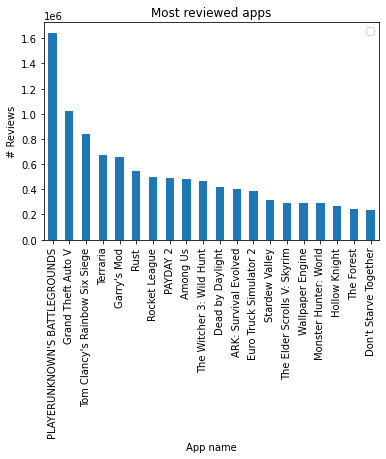

In [14]:
counts = defaultdict0()

def f(r: Review):
    counts[r.app_name] += 1

dataset.apply(f)

show_barplot_for_dict(
    counts,
    title="Most reviewed apps",
    xlabel="App name",
    ylabel="# Reviews"
);

The most reviewed app in the dataset is PUBG with ~1.6 million reviews, which along with GTA V are the only apps with over 1 million reviews.

The top apps are likely to be the most played, and indeed most of them are either AAA games, with a couple indie games mixed in.

### [RQ2.2] What applications have the best Weighted Vote Score?

10000000 entries processed...
20000000 entries processed...
30000000 entries processed...


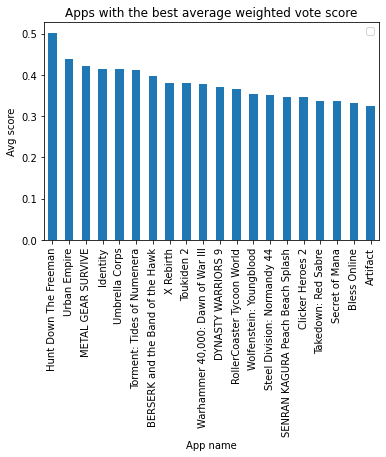

In [15]:
votes = defaultdict0()

# Here we just sum the scores. We will divide by their count, computed
# before, to extract the means.
def f(r: Review):
    votes[r.app_name] += r.weighted_vote_score

dataset.apply(f)

# We don't want apps with few reviews with a high score to be included, so
# we discard those with less than MIN_COUNT reviews.

votes = {
    # Compute the average score for each app
    app_name: score/counts[app_name]
    for app_name, score in votes.items()
    # Discard those with < MIN_COUNT reviews
    if counts[app_name] > MIN_COUNT
}

show_barplot_for_dict(
    votes,
    title="Apps with the best average weighted vote score",
    xlabel="App name",
    ylabel="Avg score"
)

del votes

By looking at the best scorers, we see that with the exception of the top entries, the others struggle to reach an average score of 0.4.

The Weighted Vote Score of a review depends on factors including the positive-to-negative ratio for all reviews on the game and the number of reviews by the author, introducing by Steam to combat issue such as review bombing and present more relevant reviews to possible customers.

Interestingly, we see some of the titles here appearing in the "least recommended" plot, presented next, possibly suggesting that individual reviews may be less helpful on critically acclaimed titles compared to ones where users' judgement are more polarized.

### [RQ2.3] Which applications have the most and the least recommendations?

10000000 entries processed...
20000000 entries processed...
30000000 entries processed...


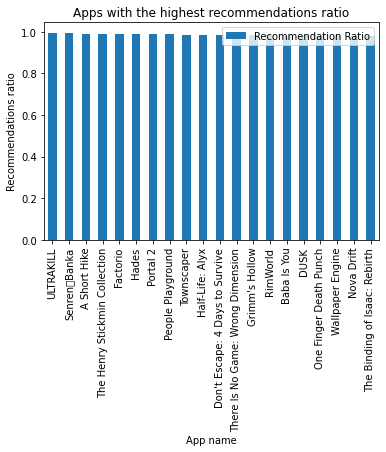

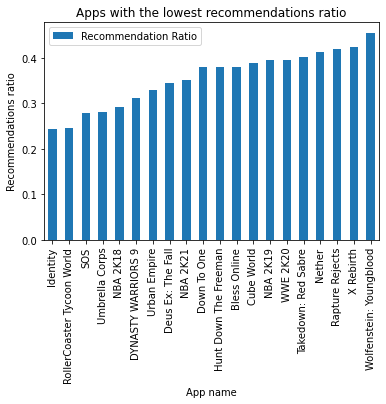

In [16]:
recommendations = defaultdict0()

def f(r: Review):
    if r.recommended:
        recommendations[r.app_name] += 1

dataset.apply(f)

# Similarly to what is done in the previous point, we compute the applications
# with the best recommendations-over-total reviews ratio, discarding outliers

recommendations = {
    app_name: recommendations_count/counts[app_name]
    for app_name, recommendations_count in recommendations.items()
    if counts[app_name] > MIN_COUNT
}

df = show_barplot_for_dict(
    recommendations,
    title="Apps with the highest recommendations ratio",
    xlabel="App name",
    ylabel="Recommendations ratio",
    column_name="Recommendation Ratio"
)

plt.show(df.nsmallest(PLOT_LIMIT, "Recommendation Ratio").plot.bar(
    title="Apps with the lowest recommendations ratio",
    xlabel="App name",
    ylabel="Recommendations ratio",
))

del recommendations

We can see there are many titles with a recommendation ratio close to 1, and indeed the titles appearing here are critically acclaimed.

On the other hand, we also notice how even the worst performers got around 1 recommendations out of 4 reviews.

This may show a bias in the analysis when it was decided to discard titles with not enough reviews. It is possible we discarded some truly terrible apps that were so bad that not many people played (and reviewed) them.
It may well be possible to find apps with a significantly lower ratio if we lowered the bar for inclusion in the plot.

### [RQ2.4] How many of these applications were purchased, and how many were given for free?

In [17]:
purchased, free = 0, 0

def f(r: Review):
    global purchased, free
    if r.received_for_free:
        free += 1
    else:
        purchased += 1

dataset.apply(f)

print(
    f"- Total reviews: {free+purchased}\n"
    f"- On apps the author received for free: {free}\n"
    f"- On apps the author purchased: {purchased}"
)

10000000 entries processed...
20000000 entries processed...
30000000 entries processed...
- Total reviews: 21747371
- On apps the author received for free: 688061
- On apps the author purchased: 21059310


As it could already be expected, most of the reviews are for apps that customers purchased. The smaller number of free apps may be due to copies given to professional reviewers in the industry or as part of promotional distributions.

## [RQ3] Reviews time

### [RQ3.1 - RQ3.2 - RQ3.3]

- What is the most common time that authors review an application? For example, authors usually write a review at 17:44.
- Create a function that receives as a parameter a list of time intervals and returns the plot the number of reviews for each of the intervals.
- Use the function that you created in the previous literal to plot the number of reviews between the following time intervals:

Here we define the function requested by RQ3.2 and use it to solve both RQ3.1 and RQ3.3

10000000 entries processed...
20000000 entries processed...
30000000 entries processed...
10000000 entries processed...
20000000 entries processed...
30000000 entries processed...


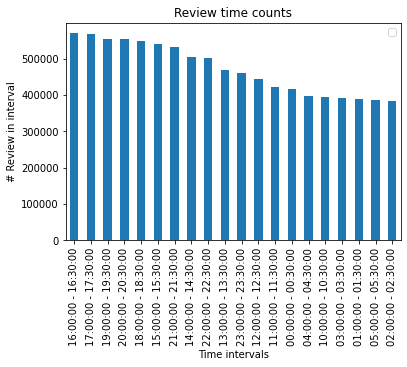

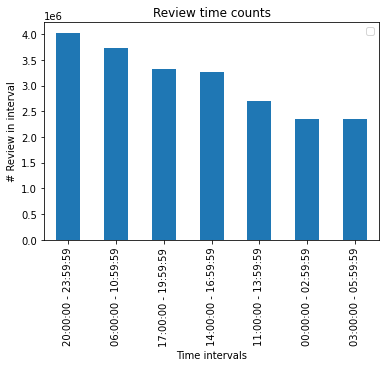

In [18]:
def plot_intervals_distributions(intervals: List[Tuple[time, time]]) -> None:
    interval_counts = [0 for _ in intervals]

    def f(r: Review):
        for index, interval in enumerate(intervals):
            start, end = interval
            if start <= r.timestamp_created.time() <= end:
                interval_counts[index] += 1

    dataset.apply(f)

    intervals_counts_dict = {
        f"{str(intervals[i][0])} - {str(intervals[i][1])}" : interval_counts[i]
        for i in range(len(intervals))
    }

    show_barplot_for_dict(
        intervals_counts_dict,
        title="Review time counts",
        xlabel="Time intervals",
        ylabel="# Review in interval"
    )

# Plot grouping by half-hour intervals
plot_intervals_distributions([
    (
        time(hour=i//2, minute=30*(i%2), second=0),
        time(hour=i//2, minute=30*((i+1)%2), second=0)
    )
    for i in range(48)
])

# Plot for RQ3.3
plot_intervals_distributions([
    (time(6), time(10,59,59)),
    (time(11), time(13,59,59)),
    (time(14), time(16,59,59)),
    (time(17), time(19,59,59)),
    (time(20), time(23,59,59)),
    (time(0), time(2,59,59)),
    (time(3), time(5,59,59)),
])

We see more or less homogeneous results, without big spikes. This is to be expected since Steam is a global store.
The most active times are in the (Italian) evening, explainable considering that most Europeans and Americans are awake at these times.
Europe and USA are also where most Steam users live, with Asian markets being relatively minor, so the latters can't sustain the same level of activity when the formers are busy or sleeping.

## [RQ4] Languages

### [RQ4.1] What are the top 3 languages used to review applications?

10000000 entries processed...
20000000 entries processed...
30000000 entries processed...


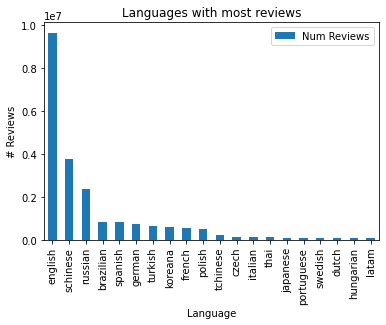

In [19]:
languages_counts = defaultdict0()

def f(r: Review):
    languages_counts[r.language] += 1

dataset.apply(f)

df = show_barplot_for_dict(
    languages_counts,
    title="Languages with most reviews",
    xlabel="Language",
    ylabel="# Reviews",
    column_name="Num Reviews"
)

del languages_counts

The number of English reviews is by far the highest, followed by (Simplified) Chinese, likely due to the high number of people speaking it, and Russian.

### [RQ4.2 - RQ4.3 - RQ4.4]

- Create a function that receives as parameters both the name of a data set and a list of languages’ names and returns a data frame filtered only with the reviews written in the provided languages.
- Use the function created in the previous literal to find what percentage of these reviews (associated with the top 3 languages) were voted as funny?
- Use the function created in the literal “a” to find what percentage of these reviews (associated with the top 3 languages) were voted as helpful?

In [20]:
# This is the function for RQ4.2, though we'll use a custom non-pandas one
def dataframe_for_languages(filename: str, languages: List[str]) -> pd.DataFrame:
    _df = pd.read_csv(filename, sep=',', header='infer')
    return _df[_df['language'].isin(languages)]

total_with_languages = 0
funny_with_languages = 0
helpful_with_languages = 0

def f(r: Review):
    global total_with_languages, funny_with_languages, helpful_with_languages

    total_with_languages += 1
    if r.votes_funny:
        funny_with_languages += 1
    if r.votes_helpful:
        helpful_with_languages += 1

languages_df = df.nlargest(3, "Num Reviews")
languages = {languages_df.iloc[i].name for i in range(3)}

dataset.apply(f, lambda r: r.language in languages)

print(f"Percentage of funny among top-3 languages: {funny_with_languages/total_with_languages*100.0}%")
print(f"Percentage of helpful among top-3 languages: {helpful_with_languages/total_with_languages*100.0}%")

10000000 entries processed...
20000000 entries processed...
30000000 entries processed...
Percentage of funny among top-3 languages: 12.208323618618321%
Percentage of helpful among top-3 languages: 29.162723635279374%


## [RQ5] Authors

### [RQ5.1] Plot the top 10 most popular reviewers and the number of reviews.

An user can show appreciation of a review by marking it as "helpful" or "funny" (possibly both).
Here we use the absolute number of appreciations of a review to compute
a review author's popularity rather than the ratio.

I chose to do use this metric assuming that someone who is "popular" is also
well-known, so that having a large but sparser following results in a higher popularity
that having a more dedicated but significantly smaller following.

Likewise, writing few high-quality reviews may not mean an author is popular unless
their reviews get widely acknowledged (which is, upvoted) by the community.

10000000 entries processed...
20000000 entries processed...
30000000 entries processed...


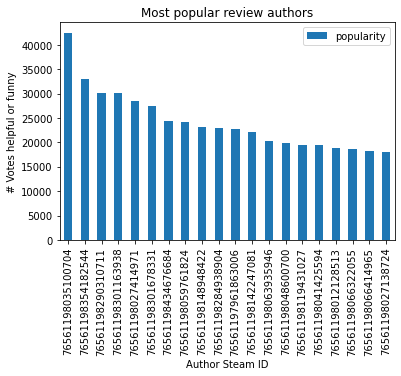

In [21]:
reviewers_popularity = defaultdict0()

def f(r: Review):
    reviewers_popularity[r.author_steamid] += r.votes_funny + r.votes_helpful

dataset.apply(f)

# There are some entries with billions of upvotes, we filter them out since they're unlikely
# to be true
reviewers_popularity = {
    author:popularity
    for author, popularity in reviewers_popularity.items()
    if popularity < 2e9
}

# Here we save the Pandas DataFrame, to be used in the next question
reviewers_popularity_df = show_barplot_for_dict(
    reviewers_popularity,
    title="Most popular review authors",
    xlabel="Author Steam ID",
    ylabel="# Votes helpful or funny",
    column_name="popularity"
)


### [RQ5.2 - RQ5.3 - RQ5.4]

- What applications did the most popular author review?
- How many applications did he purchase, and how many did he get as free?

  Provide the number (count) and the percentage.
- How many of the applications he purchased reviewed positively, and how many negatively? How about the applications he received for free?

The answers to these questions can be computed with a single pass over the dataset, hence we answer all sub-questions together.

10000000 entries processed...
20000000 entries processed...
30000000 entries processed...
Here are up to 50 apps reviewed by the most popular:
Salt and Sanctuary
Undertale
Watch_Dogs 2
The Witcher 3: Wild Hunt
BioShock Infinite
DARK SOULS™ III
Sekiro™: Shadows Die Twice
PLAYERUNKNOWN'S BATTLEGROUNDS
Total apps reviewed: 8

Received for free: 0 (0.0%)
Purchased: 8 (100.0%)


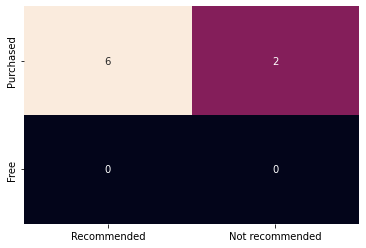

In [22]:
most_popular_author_id = reviewers_popularity_df.nlargest(1, "popularity").iloc[0].name

reviewed_by_most_popular = set()
num_purchased_and_recommended, num_purchased_and_not_recommended = 0, 0
num_free_and_recommended, num_free_and_not_recommended = 0, 0

def f(r: Review):
    global num_purchased_and_recommended, num_purchased_and_not_recommended
    global num_free_and_recommended, num_free_and_not_recommended
    if r.author_steamid == most_popular_author_id:
        reviewed_by_most_popular.add(r.app_name)

        if r.received_for_free:
            if r.recommended:
                num_free_and_recommended += 1
            else:
                num_free_and_not_recommended += 1
        else:
            if r.recommended:
                num_purchased_and_recommended += 1
            else:
                num_purchased_and_not_recommended += 1

dataset.apply(f)

num_free = num_free_and_recommended + num_free_and_not_recommended
num_purchased = (
    num_purchased_and_recommended +
    num_purchased_and_not_recommended
)
total_reviewed = num_free + num_purchased

# Let's limit the output to 50 random entries to avoid cluttering the output
print(f"Here are up to 50 apps reviewed by the most popular:")
print("\n".join(list(reviewed_by_most_popular)[:50]))

print(f"Total apps reviewed: {total_reviewed}\n")
print(f"Received for free: {num_free} ({num_free/total_reviewed*100.0}%)")
print(f"Purchased: {num_purchased} ({num_purchased/total_reviewed*100.0}%)")

df = pd.DataFrame(
    [
        [num_purchased_and_recommended, num_purchased_and_not_recommended],
        [num_free_and_recommended, num_free_and_not_recommended]
    ],
    index=["Purchased", "Free"],
    columns=["Recommended", "Not recommended"]
)
plt.show(sb.heatmap(df, annot=True, cbar=False))

A bit of a surprising result considering the low number of apps, the plot, along with the games' titles suggests, that the reviewer may have written a limited number of high-quality reviews on really popular games.

## [RQ6] Review Updates

### [RQ6.1] What is the average time (days and minutes) a user lets pass before he updates a review?

The simplest answer to this question would be to compute the average timespan between the review creation and update's timestamp's.

However, taking the average may skew the results in case a subset of user posted (and the updated) a high number of review. If that were the case, then
the computed value would be more representative of the most active users' activity rather than of the whole community.

As such, here the average time is computed as the mean of the per-user averages, computed on users who updated at least one review.

10000000 entries processed...
20000000 entries processed...
30000000 entries processed...
Average update time: 313 days, 16:20:59.377847


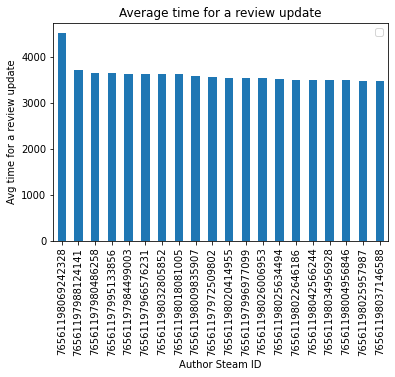

In [23]:
update_times = defaultdict0()
num_updates = defaultdict0()

def f(r: Review):
    if r.timestamp_created < r.timestamp_updated:
        update_times[r.author_steamid] += (r.timestamp_updated - r.timestamp_created).total_seconds()
        num_updates[r.author_steamid] += 1

dataset.apply(f)

update_times = compute_means(update_times, num_updates)

average_update_time = mean(update_times.values())
print(f"Average update time: {str(timedelta(seconds=average_update_time))}")

update_times_in_days = map_dict(
    update_times,
    lambda time: time/(SECONDS_IN_DAY)
)

show_barplot_for_dict(
    update_times_in_days,
    title="Average time for a review update",
    xlabel="Author Steam ID",
    ylabel="Avg time for a review update",
);

### [RQ6.2] Plot the top 3 authors that usually update their reviews

Let's compute the authors with the highest ratio of updates to reviews (rather than raw review update count).

We use a minimum number of reviews to be included in the plot so that a user that posts and updates just a handful of reviews isn't included.

10000000 entries processed...
20000000 entries processed...
30000000 entries processed...


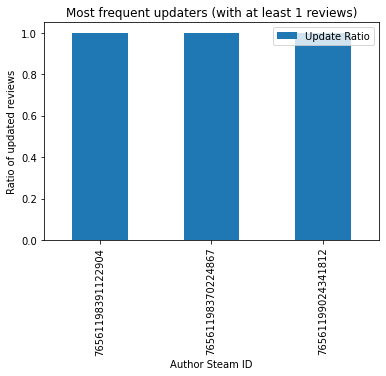

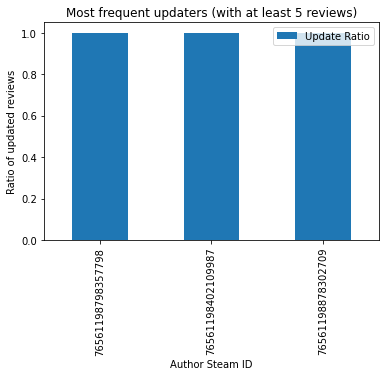

In [5]:
num_updates = defaultdict0()
num_reviews = defaultdict0()

def f(r: Review):
    if r.timestamp_created < r.timestamp_updated:
        num_updates[r.author_steamid] += 1
    num_reviews[r.author_steamid] += 1

dataset.apply(f)

update_ratios = compute_means(num_updates, num_reviews)

for min_cutoff in [1, 5]:
    update_ratios_with_cutoff = {k:v for k,v in update_ratios.items() if num_reviews[k] > min_cutoff}
    df = pd.DataFrame(
        update_ratios_with_cutoff.values(),
        columns=['Update Ratio'],
        index=update_ratios_with_cutoff.keys()
    )
    plt.show(df.nlargest(3, 'Update Ratio').plot.bar(
        title=f"Most frequent updaters (with at least {min_cutoff} reviews)",
        xlabel="Author Steam ID",
        ylabel="Ratio of updated reviews",
    ))

Would a higher cutoff change things?

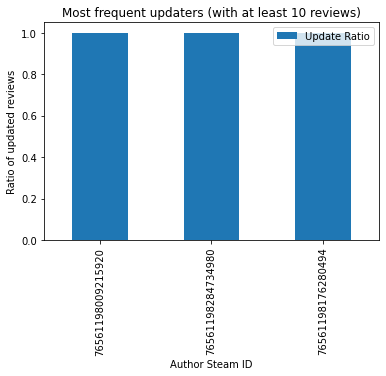

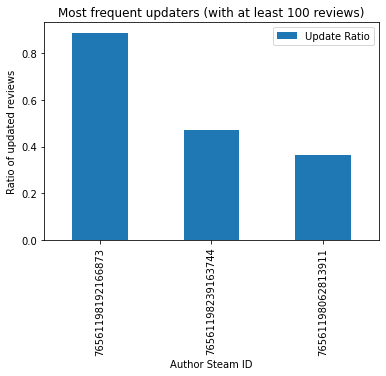

In [7]:
for min_cutoff in [10, 100]:
    update_ratios_with_cutoff = {k:v for k,v in update_ratios.items() if num_reviews[k] > min_cutoff}
    df = pd.DataFrame(
        update_ratios_with_cutoff.values(),
        columns=['Update Ratio'],
        index=update_ratios_with_cutoff.keys()
    )
    plt.show(df.nlargest(3, 'Update Ratio').plot.bar(
        title=f"Most frequent updaters (with at least {min_cutoff} reviews)",
        xlabel="Author Steam ID",
        ylabel="Ratio of updated reviews",
    ))

We get more interesting results with a higher cutoff :D

The first reviewer updated more than 80% of their reviews despite having published more than 100, and after them the ratio quickly falls.

## [RQ7] Probabilities

### [RQ7.1 - RQ7.2 - RQ7.3]

- What’s the probability that a review has a Weighted Vote Score equal to or bigger than 0.5?
- What’s the probability that a review has at least one vote as funny given that the Weighted Vote Score is bigger than 0.5?
- Is the probability that “a review has at least one vote as funny” independent of the “probability that a review has a Weighted Vote Score equal or bigger than 0.5”?

As in request 5, we can answer all the sub-questions at once.

The second sub-question asks for the WVS to be `bigger than 0.5`. For homogeneity of results with regards to the previous one,
we instead use `bigger than or equal to 0.5` also here.

In [8]:
total_reviews = 0
num_reviews_with_05_score = 0
num_reviews_funny = 0

num_reviews_funny_with_05_score = 0
num_reviews_not_funny_with_05_score = 0
num_reviews_funny_without_05_score = 0
num_reviews_not_funny_without_05_score = 0

def f(r: Review):
    global total_reviews
    global num_reviews_funny, num_reviews_with_05_score
    global num_reviews_funny_with_05_score, num_reviews_not_funny_with_05_score
    global num_reviews_funny_without_05_score, num_reviews_not_funny_without_05_score

    total_reviews += 1

    if r.weighted_vote_score >= 0.5: num_reviews_with_05_score += 1
    if r.votes_funny > 0: num_reviews_funny += 1

    if r.weighted_vote_score >= 0.5 and r.votes_funny > 0:
        num_reviews_funny_with_05_score += 1
    elif r.weighted_vote_score >= 0.5:
        num_reviews_not_funny_with_05_score += 1
    elif r.votes_funny > 0:
        num_reviews_funny_without_05_score += 1
    else:
        num_reviews_not_funny_without_05_score += 1

dataset.apply(f)

print(f"Total reviews: {total_reviews}")
print(f"Voted as funny: {num_reviews_funny} (probability {num_reviews_funny/total_reviews*100.0}%)")
print(f"With WVS >= 0.5: {num_reviews_with_05_score}")
print(f"With WVS >= 0.5 and funny: {num_reviews_funny_with_05_score}")
probability_funny_given_05_score = num_reviews_funny_with_05_score / num_reviews_with_05_score
print(f"Probability of being voted funny, given a WVS >= 0.5: {probability_funny_given_05_score*100.0}%")

10000000 entries processed...
20000000 entries processed...
30000000 entries processed...
Total reviews: 21747371
Voted as funny: 2603072 (probability 11.96959393390585%)
With WVS >= 0.5: 4784092
With WVS >= 0.5 and funny: 1191916
Probability of being voted funny, given a WVS >= 0.5: 24.914152988696706%


Looking at the results, it looks like helpful reviews are more likely to be voted as funny, which makes sense.

For the third sub-question, let's first plot a confusion matrix to get an high-level overview of the situation.

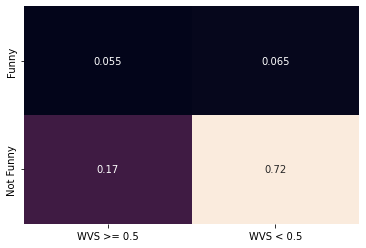

In [10]:
df = pd.DataFrame(
    [
        [num_reviews_funny_with_05_score/total_reviews, num_reviews_funny_without_05_score/total_reviews],
        [num_reviews_not_funny_with_05_score/total_reviews, num_reviews_not_funny_without_05_score/total_reviews]
    ],
    index=["Funny", "Not Funny"],
    columns=["WVS >= 0.5", "WVS < 0.5"]
)
plt.show(sb.heatmap(df, annot=True, cbar=False))

Let's also be more explicit with the results.

Let's use the following predicates for conciseness
- F(r) := review r is funny
- S(r) := review r has a WVS >= 0.5

By definition, F(r) and S(r) are independent if

P(F(R) & S(R)) = P(F(r))P(S(r))

Let's check whether that's the case:

In [11]:
print(f"P(F(r) & S(R)) = {num_reviews_funny_with_05_score/total_reviews}")
p_f = num_reviews_funny/total_reviews
p_s = num_reviews_with_05_score/total_reviews
print(f"P(F(r)) = {p_f}")
print(f"P(S(r)) = {p_s}")
print(f"P(F(r))*P(S(r)) = {p_f*p_s}")

P(F(r) & S(R)) = 0.05480736039312522
P(F(r)) = 0.1196959393390585
P(S(r)) = 0.21998484322541792
P(F(r))*P(S(r)) = 0.026331292450221918


Looking at the numbers, the two probabilities are likely unrelated

## [RQ8] Testing Hypotheses

### [RQ8.1] Is there a significant difference in the Weighted Vote Score of reviews made in Chinese vs the ones made in Russian? Use an appropriate statistical test or technique and support your choice.

10000000 entries processed...
20000000 entries processed...
30000000 entries processed...


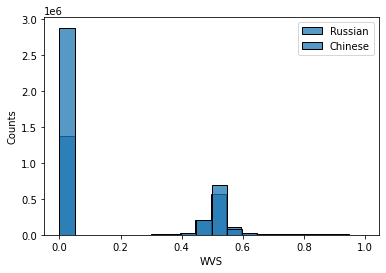

In [3]:
russian_languages = {"russian"}
chinese_languages = {"schinese", "tchinese"}

russian_scores = []
chinese_scores = []

def f(r: Review):
    if r.language in russian_languages:
        russian_scores.append(r.weighted_vote_score)
    elif r.language in chinese_languages:
        chinese_scores.append(r.weighted_vote_score)

dataset.apply(f)

sb.histplot(russian_scores, bins=20, label="Russian")
sb_plot = sb.histplot(chinese_scores, bins=20, label="Chinese")
sb_plot.set(xlabel='WVS', ylabel='Counts')
plt.legend()
plt.show()

Most of the reviews have a WVS of either 0 or 0.5. Even without using actual statistical tests, we see the distributions to be similar, with many more reviews being unheplful rather than the alternative.

It is still possible to see how much more likely Chinese reviews are to be unhelpful. There are roughly twice as many unhelpful Chinese reviews than Russian ones, but the same behavior can't be observed in helpfuk reviews.

### [RQ8.2] Can you find any significant relationship between the time that a user lets pass before he updates the review and the Weighted Vote Score? Use an appropriate statistical test or technique and support your choice.

Let's compute the Pearson correlation between the two variables.

In [7]:
days_until_update = []
weighted_vote_scores = []
is_recommended = []

def f(r: Review):
    if r.timestamp_updated > r.timestamp_created:
        days_until_update.append((r.timestamp_updated - r.timestamp_created).total_seconds()/SECONDS_IN_DAY)
        weighted_vote_scores.append(r.weighted_vote_score)
        is_recommended.append(1 if r.recommended else 0)

dataset.apply(f)

correlation, p = sp.stats.pearsonr(days_until_update, weighted_vote_scores)
print(f"Correlation: {correlation}")
print(f"P-value: {p}")

10000000 entries processed...
20000000 entries processed...
30000000 entries processed...
Correlation: -0.036264286649939706
P-value: 0.0


### [RQ8.3] Is there any change in the relationship of the variables mentioned in the previous literal if you include whether an application is recommended or not in the review? Use an appropriate statistical test or technique and support your choice.

In [8]:
from matplotlib.colors import ListedColormap

days_until_update_if_recommended = [d for i,d in enumerate(days_until_update) if is_recommended[i]]
days_until_update_if_not_recommended = [d for i,d in enumerate(days_until_update) if not is_recommended[i]]
weighted_vote_scores_if_recommended = [s for i,s in enumerate(weighted_vote_scores) if is_recommended[i]]
weighted_vote_scores_if_not_recommended = [s for i,s in enumerate(weighted_vote_scores) if not is_recommended[i]]

correlation, p = sp.stats.pearsonr(days_until_update_if_recommended, weighted_vote_scores_if_recommended)
print("If recommended:")
print(f"- Correlation: {correlation}")
print(f"- P-value: {p}")
print()
correlation, p = sp.stats.pearsonr(days_until_update_if_not_recommended, weighted_vote_scores_if_not_recommended)
print("If not recommended:")
print(f"- Correlation: {correlation}")
print(f"- P-value: {p}")

del days_until_update, weighted_vote_scores

If recommended:
- Correlation: -0.017765069699434057
- P-value: 1.0920237416304822e-135

If not recommended:
- Correlation: -0.09614701102384161
- P-value: 0.0


The correlation and p-value seem to imply a basically null correlation between the two variables, regardless of whether we only consider all the updated reviews, or only those (not) recommended.

### [RQ8.4 - RQ8.5]

- Histograms

Histograms are mainly used to plot probabiltiy distributions of values that can belong to one of several bins (identified by number or intervals), and the Y axis counts the number of occurrences for each bin.

Unlike bar plots, the bins are usually sorted on the X axis in increasing order of their key to actually plot the probability distribution rather than just raw counts.

The Y axis is then used to plot the frequencies with which entries fall into each bin's value or interval.

- Bar Plot

Similar to histograms, but the bins are not contiguous and usually refer to categories, rather than interval.

- Scatterplot

Scatterplots display entries as points on a n-dimentional graph according to the value of n variables (with n usually being 2 or 3), each of which is mapped onto an axis.

By using them, it is possible to observe relationships between the axis variables, especially how changing one of them influences the others, or whether there are particular combinations with a higher probabilities (shown by a higher density of entries in some areas over others).

- Pie Charts

Pie charts show label-value pairs on a circular graph. It is similar to a pie in that values are represented as slices of the cake, with their size being proportional to the associated value.

This representation is particularly helpful to show how the values compare to one another, often resulting in the smallest entries being visually negligible, while the biggest ones are more evident.

- Box Plot

A box plot is used to display statistical information about distributions.

They show a vertical box whose extremes correspond on the Y axis to the first and third quartiles.

A line inside the box marks the median value, and from the top and bottom two lines ("whiskers") extend until the maximum and minimum values in the distribution. It is also possible to filter outliers to avoid them from making the whiskers unnecessarily long.

# Theoretical Questions

TQ1
===

TQ1.1
---

Given an array of real numbers `A` of length `n` and an integer `k` such that `1 <= k <= n`, the algorithm computes the `k`-th smallest value in A.

The algorithm works as follows:
1. First it picks a random element `s` from A, and splits `A` in two subarrays `L` and `R`, with the former containing all values `v` of `A` such that `v <= s`, and the latter the remaining ones (which is, all `v'` in `A` such that `v' > s`). Note that `A` is not sorted (otherwise computing the `k`-th smallest value would be trivial), and by construction neither are `L` and `R`.

2. Now, three possible scenarios are possible depending on the relationship between `len(L)` and `k`:

    - If `len(L) == k` then `s` is returned, since it must be the `k`-th smallest element in A. This is because, since there are exactly `k` values in `A` that are no greater than `s`, and `s` is actually in the array `A`, then `s` must be the `k`-th smallest.
    - If `len(L) < k`, then the algorithm recurses using `L` as the new value of `A` and `k` as itself.
    - If `len(L) > k`, then the algorithm recurses using `R` as the new value of `A`. Concerning the `k` parameter, `k-len(L)` is used to account for the elements in `L` that have to be skipped when searching looking for the desired value, since the `n`-th smallest element in `R` is the `n+len(L)` in `A`.

    In the second and third case, the algorithm may recurse indefinitely until `len(A) == 1`, in which case the only value in `A` is returned.

TQ1.2
---

The algorithm's running time depends on the random selections of `s` at each invocation of the algorithm (either the first call or recursive ones). The worst case happens when either the smallest or biggest value in the array is repeatedly picked as `s` and `k` is close to the other extreme (i.e. either `k` is low and a high value is repeatedly picked as `s`, or vice versa).
In that case, at each step the algorithm `A` gets split into two subarrays, one of length equal to 1, which gets discarded, and another of length `len(A)-1` on which the algorithm recurses.

Considering that splitting `A` into `L` and `R` has a complexity of O(n), the big-O complexity analysis in this case yields a complexity of O(n^2) either by applying the Master Theorem, or by explicitly summing the complexity of splitting `A` at each recursion level, with `len(A)` splitting operations of linear complexity applied to arrays of size `2,3,...,len(A)` yielding again O(n^2) by Gauss sum.

TQ1.3
---

In the best case, the `k`-th smallest value in `A` is randomly picked as `s` the first time the algorithm is executed.

Since the recursion step is never executed, the resulting complexity is given by the time required to split `A` into `L` and `R`, which by being linear yields a best-case complexity of O(n).

TQ2
===

TQ2.1
---

The algorithm reverses the array that is passed as its first argument (provided that in the initial invocation 0 and the array's length are passed as second and third argument).

The complexity of `swapList` is trivially linear in the length of its array argument (actually half its length, but the `0.5` factor is discarded in big-O analysis), leading to `splitSwap` having a recurrence relation of T(n) = 2T(n/2) + O(n).

By applying the Master Theorem, the result for overall algorithm's complexity is `O(n*log(n))` since the complexities of splitting and recombining the problem are comparable.

The same result can be easily computed by summation, and the algorithm's running time is actually `Θ(n*log(n))`, since the algorithm recurses for `log2(n)` levels and at each step computes a number of `swapList`s equal to `2^level`, each on an array of size `len(a)/(2^level)`, totalling `O(n)` complexity for each recursion level.

TQ2.2
---

The algorithm works recursively by first reversing its first and second halves independently (in the recursive step), then by swapping these halves by assuming them to be reversed.

In the recursive step, recursion proceeds indefinitely until the two halves are of length equal to 1. The recursive steps are no-ops as they return immediately, then `swapList` just swaps these two elements (the description assumes the array to be of size `2^n` for some integer `n` for simplicity, but the algorithm works even when that's not the case).

More generally, `swapList` iterates an array up to its midpoint, swapping its `i`-th element with the `i`-th after the midpoint, effectively swapping the array's first and second halves.

After the last recursion level is reached, the recombination step runs on bigger and bigger arrays, each with its two halves in the correct order, until the whole array is finally reversed.

We noted above that the algorithm's complexity is linearithmic in the array's size, though now that we know what it does it's trivial to show its not optimal by providing an optimal implementation running in `Θ(n)`, shown next:

```
function reverseArray(a,l,n):
    for i=0 to n/2:
        tmp = a[i]
        a[i] = a[n-1-i]
        a[n-1-i] = tmp
```

Just as `splitSwap`, `reverseArray` is meant to be called as `reverseArray(a,0,len(a))`.

TQ3
===

TQ3.1
---

```
W = 2

w_1 = 1, v_1 = 1
w_2 = 2, v_2 = 2
```

The first heuristic select `i_1` to be included, then stops as it has no more room for `i_2`. The resulting value in the knapsack is 1, but it would have been `2` by selecting only `i_2`.

TQ3.2
---

```
W = 2

w_1 = 2, v_1 = 3
w_2 = 1, v_2 = 2
w_3 = 1, v_3 = 2
```

The second heuristic selects only `i_1` to be included, since it has the highest value and then there's no more room for other items.
The resulting value is 3, but it would have been 4 by selecting `i_2` and `i_3`, which could fit together in the knapsack.

TQ3.3
---

```
W = 4

w_1 = 3, v_1 = 4
w_2 = 2, v_2 = 2.5
w_3 = 2, v_3 = 2.5
```

The third heuristic only selects `i_1` since it has the highest value-to-cost ratio and then there's no more room for other items.
The resulting value is 4, but it would have been 5 by selecting `i_2` and `i_3`, which could fit together in the knapsack.